# Integrated gradients for resenet model trained on Imagenet dataset

In this notebook we show the usage of the IntegratedGradients class on sample images from imagenet and for a pretrained resnet model. 

The IntegratedGradients class implements the integrated gradients features attributions method. A description of the method can be found [here](../doc/source/methods/IntegratedGradients.ipynb). Integrated gradients was originally proposed in here [here](https://arxiv.org/abs/1703.01365).

In [81]:
import numpy as np
import os
import json
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from alibi.datasets import fetch_imagenet
%set_env CUDA_VISIBLE_DEVICES=3
tf.test.is_gpu_available()

env: CUDA_VISIBLE_DEVICES=3


True

In [87]:
def magnify_attrs(attrs):
    return 3 * (attrs / attrs.max())

def plot_attributions(model, data, labels, attrs, figsize=(20, 15)):

    with open("../alibi/data/imagenet_class_names_to_label_idx.json", 'r') as f:
        class_names_to_label_idx = json.load(f)
        f.close()
        label_idx_to_class_names = {v: k for k, v in class_names_to_label_idx.items()}
    
    ncols = 4
    nrows = 3
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    n_subplot = 1

    for i in [0, 1, 9]:
        X_i = data[i]
        X_i = (X_i / 255).astype('float32')
        attrs_i = attrs[i]
        attrs_plus_i = attrs_i.copy()
        attrs_minus_i = -attrs_i.copy()
        attrs_plus_i[attrs_plus_i < 0] = 0
        attrs_minus_i[attrs_minus_i < 0] = 0
        attrs_i = magnify_attrs(attrs_i)
        attrs_minus_i = magnify_attrs(attrs_minus_i)
        attrs_plus_i = magnify_attrs(attrs_plus_i)
        
        label = labels[i]
        pred = np.argmax(model(X_i.reshape((1, ) + X_i.shape)).numpy(), axis=1)
        pred_name = label_idx_to_class_names[pred[0]]
        
        # original image
        plt.subplot(nrows, ncols, n_subplot)
        if i == 0:
            plt.title('Original image. \n True label: persian cat. \n Model prediction: {}'.format(pred_name))
        else:
            plt.title('\n Model prediction: {}'.format(pred_name))
        
        plt.imshow(X_i)
        n_subplot += 1
        
        # all attributions
        plt.subplot(nrows, ncols, n_subplot)
        if i == 0:
            plt.title('All Attributions')
        plt.imshow(attrs_i)
        n_subplot += 1

        # positive attributions
        plt.subplot(nrows, ncols, n_subplot)
        if i == 0:
            plt.title('Positive Attributions')
        plt.imshow(attrs_plus_i)
        n_subplot += 1

        # negative attributions
        plt.subplot(nrows, ncols, n_subplot)
        if i == 0 :
            plt.title('Negative Attributions')
        plt.imshow(attrs_minus_i)
        n_subplot += 1
   
    plt.show()

## Load data

For the sake of the example, we load 10 images from the imagenet dataset, all belonging to the category "Persian cat". 

In [39]:
category = 'Persian cat'
image_shape = (224, 224, 3)
data, labels = fetch_imagenet(category, nb_images=10, target_size=image_shape[:2], seed=2, return_X_y=True)
print('Images shape: {}'.format(data.shape))

Images shape: (10, 224, 224, 3)


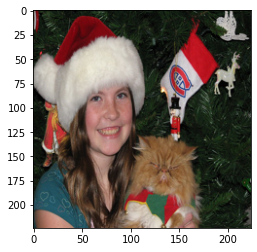

In [40]:
i = 1
plt.imshow(data[i]);

## Load model

We load a pretrained tensorflow model with an ResNet architecture trained on the imagenet dataset.

In [4]:
model = ResNet50V2(weights='imagenet')

## Calculate integrated gradients

In [5]:
n_steps = 50
method = "gausslegendre"
return_convergence_delta = True
return_predictions = False
ig  = IntegratedGradients(model,
                          n_steps=n_steps, 
                          method=method,
                          return_convergence_delta=return_convergence_delta, 
                          return_predictions=return_predictions)

In [6]:
explanation = ig.explain(data, 
                         baselines=None, 
                         target=labels,
                           internal_batch_size=50)

In [7]:
attrs = explanation.data['attributions']

## Visualize attributions

Show sample image from the first 10 images of the test dataset.The attributions are scaled by an appropriate factor for visualization purposes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


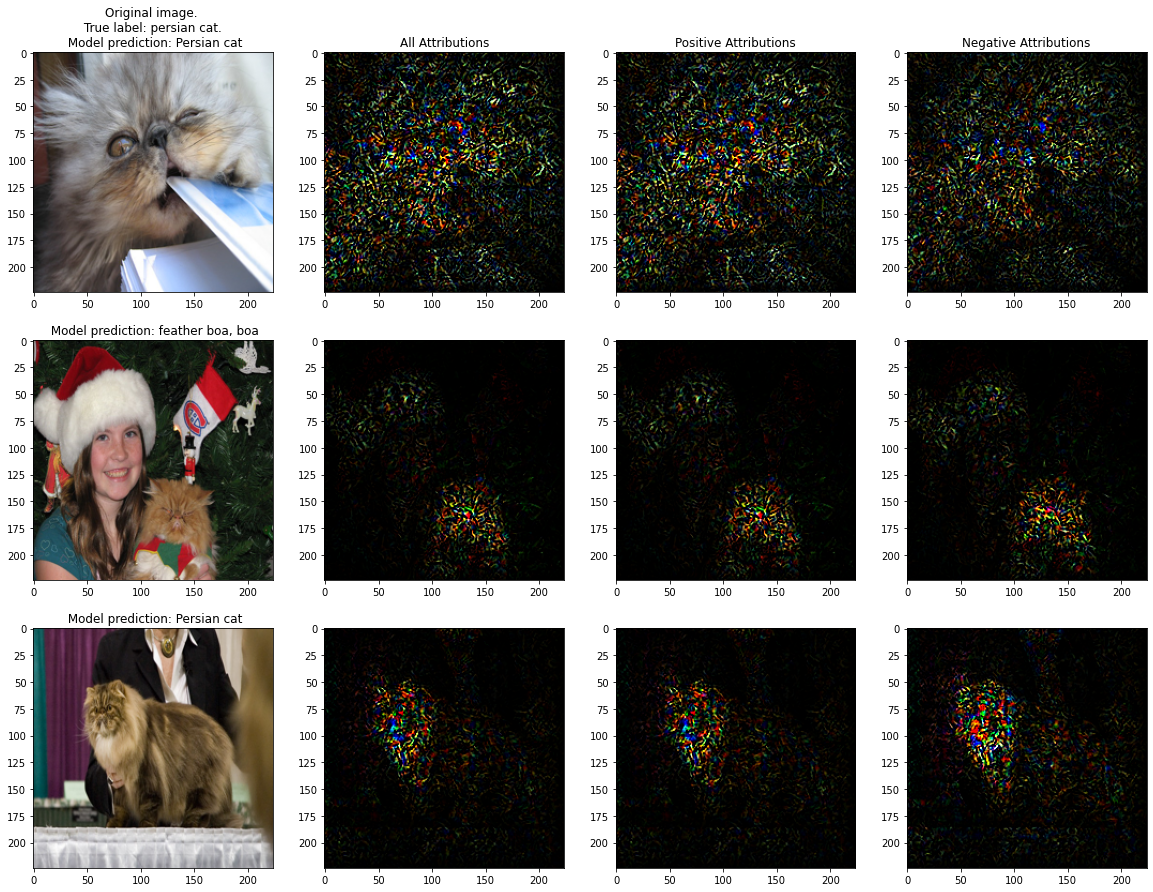

In [88]:
plot_attributions(model, data, labels, attrs, figsize=(20, 15))